In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings
from smc.aggregate import Aggregate

import torch
# torch.cuda.is_available()
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

### Generate images

We specify a prior and an image model and generate one image.

In [2]:
TruePrior = StarPrior(max_objects = 60,
                      image_height = 32,
                      image_width = 32,
                      min_flux = 10000)

TrueImageModel = ImageModel(image_height = 32,
                            image_width = 32,
                            psf_stdev = 0.75,
                            background = 20000)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

image 1 
count
 33 
total flux
 3394780.5 
loc
 [[25.637928    9.798461  ]
 [24.780464   15.702155  ]
 [26.211668   19.67124   ]
 [14.067898   30.811087  ]
 [ 1.2666864  11.666288  ]
 [20.973898   17.359768  ]
 [ 0.9637675   7.8231506 ]
 [ 9.47613     8.684716  ]
 [12.462798    2.340015  ]
 [ 2.3871396  29.597902  ]
 [10.151333   19.246822  ]
 [14.11454     4.282163  ]
 [ 8.650599   22.237644  ]
 [16.854795    9.225234  ]
 [22.641296    7.4334035 ]
 [26.353296    7.1042566 ]
 [26.024021   27.60404   ]
 [18.123497   24.97515   ]
 [ 9.638805   27.877249  ]
 [24.355623    6.761932  ]
 [25.353703   31.81017   ]
 [28.702658   17.471746  ]
 [31.000463   22.820454  ]
 [25.431887    1.7144382 ]
 [19.040216    6.304891  ]
 [29.184542    3.0035214 ]
 [15.487683    8.251824  ]
 [ 3.3815932  15.902832  ]
 [20.073372   13.326927  ]
 [28.22878    10.0967455 ]
 [22.867243    0.30186135]
 [28.490618   25.878647  ]
 [ 9.928717   29.740393  ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.  

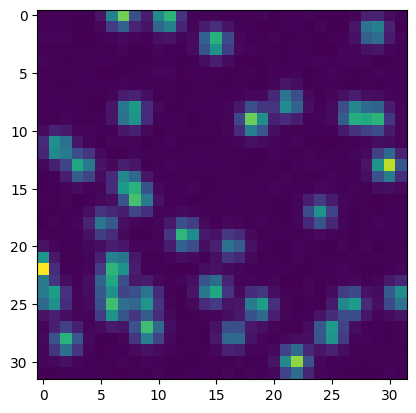

In [3]:
for i in range(1):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")
    fig, img = plt.subplots(1,1)
    _ = img.imshow(images[i].cpu())

### Perform inference with SMC

We set the side length of the tiles on which we will run the sampler, and we specify a prior and image model at the tile level. We also specify a mutation kernel to be used within the SMC sampler.

In [4]:
tile_dim = 8

TilePrior = StarPrior(max_objects = 5,
                      image_height = tile_dim,
                      image_width = tile_dim,
                      min_flux = 10000,
                      pad = 4)

TileImageModel = ImageModel(image_height = tile_dim,
                            image_width = tile_dim,
                            psf_stdev = 0.75,
                            background = 20000)

MHKernel = MetropolisHastings(num_iters = 100,
                              locs_stdev = 0.1,
                              features_stdev = 2000)

Now we initialize an `SMCsampler` object and run it on the tiles.

In [5]:
smc = SMCsampler(image = images[0],
                 tile_dim = tile_dim,
                 Prior = TilePrior,
                 ImageModel = TileImageModel,
                 MutationKernel = MHKernel,
                 num_catalogs_per_count = 500,
                 max_smc_iters = 500)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()

True count: 33
True total flux: 3394780.5

Starting the tile samplers...
iteration 5, temperature = 0.0004699373384937644
iteration 10, temperature = 0.0027811070904135704
iteration 15, temperature = 0.010525243356823921
iteration 20, temperature = 0.03366023302078247
iteration 25, temperature = 0.10285073518753052
iteration 30, temperature = 0.3161564767360687
Done!

summary
number of SMC iterations: 33
posterior mean count by tile:
tensor([[1.8500, 2.0000, 0.1600, 1.0000],
        [2.0000, 1.0300, 2.0000, 4.0000],
        [3.0000, 4.0000, 1.0000, 1.0000],
        [5.0000, 3.0000, 3.0000, 3.0000]], device='cuda:5')


Now we instantiate an `Aggregate` object with the tile-level results from above:

In [6]:
agg = Aggregate(smc.Prior,
                smc.ImageModel,
                smc.tiled_image,
                smc.counts,
                smc.locs,
                smc.features,
                smc.weights_intercount)

And we run the aggregation procedure to obtain image-level catalogs:

In [7]:
agg.run()

We compute the posterior mean number of light sources:

In [8]:
(agg.weights * agg.counts).squeeze().sum().round(decimals=2).item()

37.0

And we compute the posterior mean total flux:

In [9]:
(agg.weights * agg.features.sum(3)).squeeze().sum().item()

2978028.75